<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/main/notebooks/dev/toy_model_to_test_apt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Imports { display-mode: "form" }

!pip install --quiet --upgrade dm-haiku optax 
!pip install --quiet git+https://github.com/Justinezgh/SBI-Diff-Simulator@u/Justinezgh/train_model
!pip install --quiet chainconsumer
!pip install --quiet numpyro

import logging
# Removing annoying TFP error message
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())


%pylab inline
import arviz as az
az.style.use("arviz-white")
import jax
import jax.numpy as jnp
import haiku as hk
import optax
from tqdm import tqdm
from functools import partial
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP, AffineCoupling, MLP
from sbids.tasks.two_moons import get_two_moons
from jax.experimental.ode import odeint
from sbids.train_models import train_model
import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

/usr/local/lib/python3.9/dist-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


# Create numpyro toy gaussian model

In [2]:
# create prior and proposal distributions
prior = tfd.Normal(0.5 * jnp.ones(2), 0.1 * jnp.ones(2)).sample(10000, jax.random.PRNGKey(0))
proposal = tfd.Normal(0.5 * jnp.ones(2), 0.08 * jnp.ones(2)).sample(10000, jax.random.PRNGKey(0))

In [3]:
# numpyro model 
def gaussian_model(): 

  theta = numpyro.sample(
      'theta', 
      dist.Normal(0.5 * jnp.ones(2), 0.1 * jnp.ones(2))
    )

  y = numpyro.sample(
      'y', 
      dist.Normal(theta, 0.05 * jnp.ones(2))
    )
  
  return y

In [4]:
# create fiducial 
model_trace = trace(seed(
    gaussian_model, 
    jax.random.PRNGKey(0)
)).get_trace()

theta_fid = model_trace['theta']['value']
observation = model_trace['y']['value']

print('theta fiducial: ', theta_fid)
print('observation: ', observation)

theta fiducial:  [0.51930773 0.4473217 ]
observation:  [0.5197431  0.44487745]


In [5]:
# compute posterior 
observed_model = condition(gaussian_model, {'y': observation})

nuts_kernel = numpyro.infer.NUTS(
    observed_model,
    init_strategy=numpyro.infer.init_to_median,
    max_tree_depth=6,
    step_size=0.1)

mcmc = numpyro.infer.MCMC(nuts_kernel,
                          num_warmup=300,
                          num_samples=10000,
                          progress_bar=True)

mcmc.run(jax.random.PRNGKey(0))
samples = mcmc.get_samples()

sample: 100%|██████████| 10300/10300 [00:44<00:00, 231.26it/s, 3 steps of size 8.94e-01. acc. prob=0.92]


/usr/local/lib/python3.9/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


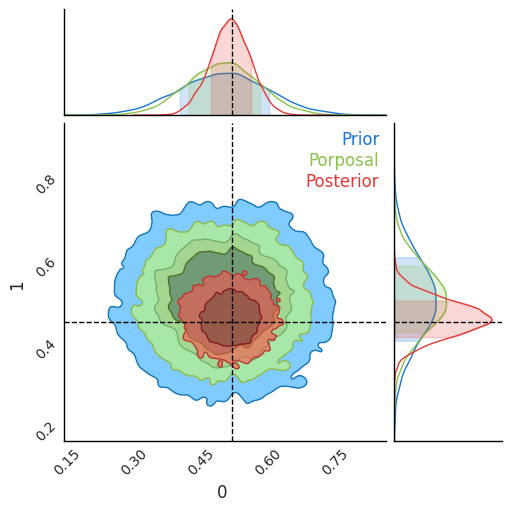

In [6]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(prior, name = 'Prior')
c.add_chain(proposal, name = 'Porposal')
c.add_chain(samples['theta'], name = 'Posterior')
fig = c.plotter.plot(figsize="column", truth = list(theta_fid))

In [7]:
# numpyro model that sample from the proposal 
def gaussian_model_proposal(): 

  theta = numpyro.sample(
      'theta', 
      dist.Normal(0.5 * jnp.ones(2), 0.08 * jnp.ones(2))
    )

  y = numpyro.sample(
      'y', 
      dist.Normal(theta, 0.05 * jnp.ones(2))
    )
  
  return y

# Experiments To do

Test to do with **Not Smooth NF**

    1.  Learn the posterior from the prior
      a. with nll loss
      b. with apt loss 

    -> should get the same contours. 

    If validated:

    2.  Learn the posterior from the proposal
      a. with nll loss
      b. with apt loss 

    -> if it works then apt loss is validated and we can test it on our smooth nf

Do the same steps with **Smooth NF**.






In [8]:
smooth = False
proposal = False
loss_apt = False

# SBI

In [9]:
# create dataset 

from sbids.tasks.utils import get_samples_and_scores


if proposal: 
  model = gaussian_model_proposal
else: 
  model = gaussian_model

nb_simu_max = 10000
(_, samples), scores = get_samples_and_scores(
    model, 
    jax.random.PRNGKey(1), 
    batch_size=nb_simu_max
)

mu = samples['theta']
batch = samples['y']

In [10]:
# nf model

if smooth: 
  bijector = partial(
    AffineSigmoidCoupling, 
    layers = [256, 256, 256],
    n_components = 16, 
    activation = jax.nn.silu
  )

else:
  bijector = partial(
      AffineCoupling, 
      layers = [256, 256, 256],
      activation = jax.nn.silu
  )

NF = partial(
    ConditionalRealNVP, 
    n_layers = 4, 
    bijector_fn = bijector
)

model_nf = hk.without_apply_rng(hk.transform(
    lambda p, x : NF(2)(x).log_prob(p))
)

In [14]:
# create loss: 

if loss_apt: 

  # apt loss from https://github.com/mackelab/sbi/blob/928750591d77f7ef1d8879721f54b9f3f74973de/sbi/inference/snpe/snpe_c.py#L282
  # https://arxiv.org/pdf/1905.07488.pdf

  import torch 

  def loss_fn(
      model_params,
      theta,
      x,
      score,
      score_weight
  ):
          

      num_atoms = 10
      batch_size = len(theta)
      repeat_y = jnp.repeat(x, num_atoms, axis = 0)
    
      probs = torch.ones(batch_size, batch_size) * (1 - torch.eye(batch_size)) / (batch_size - 1)

      choices = torch.multinomial(
          probs, 
          num_samples=num_atoms - 1, 
          replacement=False
      )
      choices = jnp.array(choices)
      contrasting_theta = jnp.array(theta[choices])

      atomic_theta = jnp.concatenate([
          theta[:, None, :], 
          contrasting_theta],
          axis=1
          ).reshape(batch_size * num_atoms, -1)

      log_prob_posterior = jax.vmap(
          lambda theta, x: model_nf.apply(
            model_params, 
            theta.reshape([1,2]), 
            x.reshape([1,2])
          )
      )(jnp.array(atomic_theta), repeat_y)

      log_prob_posterior = log_prob_posterior.reshape([batch_size, num_atoms])

      prior = tfd.Normal(0.5 * jnp.ones(2), 0.1 * jnp.ones(2))
      log_prob_prior = prior.log_prob(atomic_theta).sum(axis=1)
      log_prob_prior = log_prob_prior.reshape(batch_size, num_atoms)

      unnormalized_log_prob = log_prob_posterior - log_prob_prior

      log_prob_proposal_posterior = unnormalized_log_prob[:, 0] 
      log_prob_proposal_posterior -= tfp.math.reduce_weighted_logsumexp(
          unnormalized_log_prob, 
          axis=1
      )

      return -jnp.mean(log_prob_proposal_posterior) 


else: 
  def loss_fn(
    model_params,
    theta,
    x,
    score,
    score_weight
  ):
          
      log_prob_posterior = jax.vmap(
          lambda theta, x: model_nf.apply(
            model_params, 
            theta.reshape([1,2]), 
            x.reshape([1,2])
          )
      )(theta, x)

      return -jnp.mean(log_prob_posterior) 

In [15]:
# update function 

@jax.jit
def update(params, opt_state, weight, mu, batch,score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, mu, batch,score, weight)
    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

/usr/local/lib/python3.9/dist-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
100%|██████████| 5000/5000 [01:02<00:00, 80.14it/s]
/usr/local/lib/python3.9/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


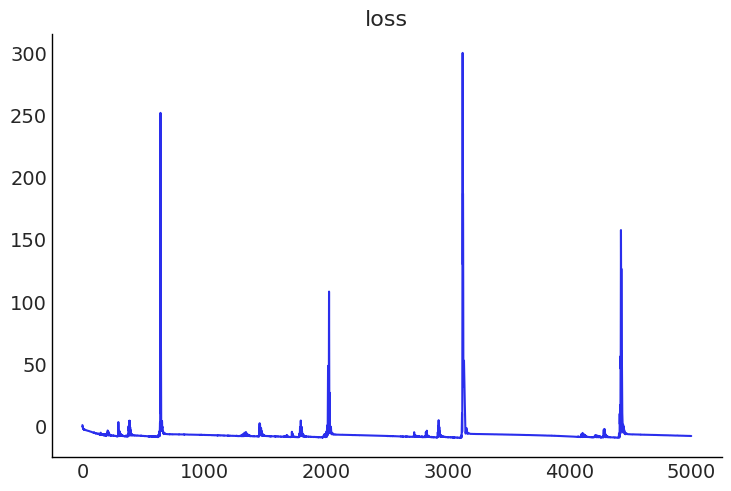

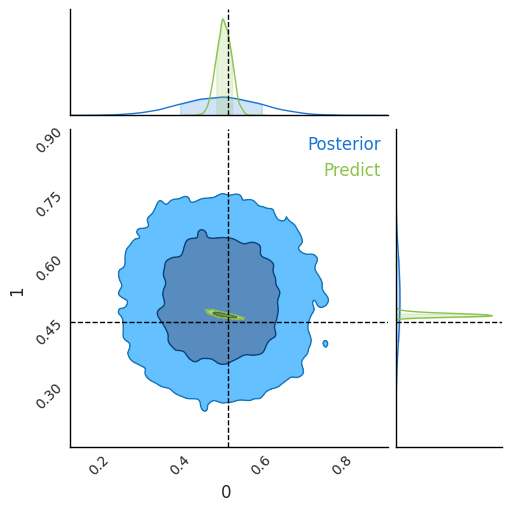

In [16]:
# training 

rng_seq = hk.PRNGSequence(12)
params_nd = model_nf.init(
    next(rng_seq), 
    p=jnp.zeros([1,2]), 
    x=jnp.zeros([1,2])
)

learning_rate=0.0001
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params_nd)

total_step = 5000
batch_loss = []
for step in tqdm(range(total_step)):
    inds = np.random.randint(0, nb_simu_max, 128) 
    l, params_nd, opt_state = update(
        params_nd, 
        opt_state, 
        0, 
        mu[inds], 
        batch[inds],
        scores[inds]
    )
    batch_loss.append(l)
    if jnp.isnan(l):
      break


plot(batch_loss)
title('loss')


sample_model = hk.transform(
      lambda x :  NF(2)(x).sample(10000, seed=hk.next_rng_key()))

predicted_sample = sample_model.apply(
    params_nd, 
    rng = next(rng_seq),
    x = observation * jnp.ones([10000, 2])
)

from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_chain(samples['theta'], name = 'Posterior')
c.add_chain(predicted_sample, name = 'Predict')
fig = c.plotter.plot(figsize="column", truth = list(theta_fid))